In [ ]:
pip install grad-cam opencv-python

In [ ]:
!pip install -U "numpy<2.0" "scipy<1.13" "scikit-learn"

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Train: 2611 images, Val/Test: 653 images
Using device: cuda:0
Building EnsembleModel with: ['swin_small_patch4_window7_224', 'deit_base_distilled_patch16_224', 'convnext_small']


model.safetensors:   0%|          | 0.00/200M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Training Ensemble BTGC model...
Epoch 1/30
----------
Train Loss: 0.5431 Acc: 0.8418
Val Loss: 0.3308 Acc: 0.9571
New best validation accuracy: 0.9571

Epoch 2/30
----------
Train Loss: 0.2848 Acc: 0.9717
Val Loss: 0.3775 Acc: 0.9219

Epoch 3/30
----------
Train Loss: 0.2607 Acc: 0.9770
Val Loss: 0.2852 Acc: 0.9709
New best validation accuracy: 0.9709

Epoch 4/30
----------
Train Loss: 0.2340 Acc: 0.9900
Val Loss: 0.2731 Acc: 0.9724
New best validation accuracy: 0.9724

Epoch 5/30
----------
Train Loss: 0.2266 Acc: 0.9923
Val Loss: 0.2751 Acc: 0.9678

Epoch 6/30
----------
Train Loss: 0.2211 Acc: 0.9931
Val Loss: 0.2573 Acc: 0.9801
New best validation accuracy: 0.9801

Epoch 7/30
----------
Train Loss: 0.2242 Acc: 0.9908
Val Loss: 0.2617 Acc: 0.9816
New best validation accuracy: 0.9816

Epoch 8/30
----------
Train Loss: 0.2189 Acc: 0.9939
Val Loss: 0.2639 Acc: 0.9801

Epoch 9/30
----------
Train Loss: 0.2143 Acc: 0.9966
Val Loss: 0.2641 Acc: 0.9770

Epoch 10/30
----------
Train Loss: 0

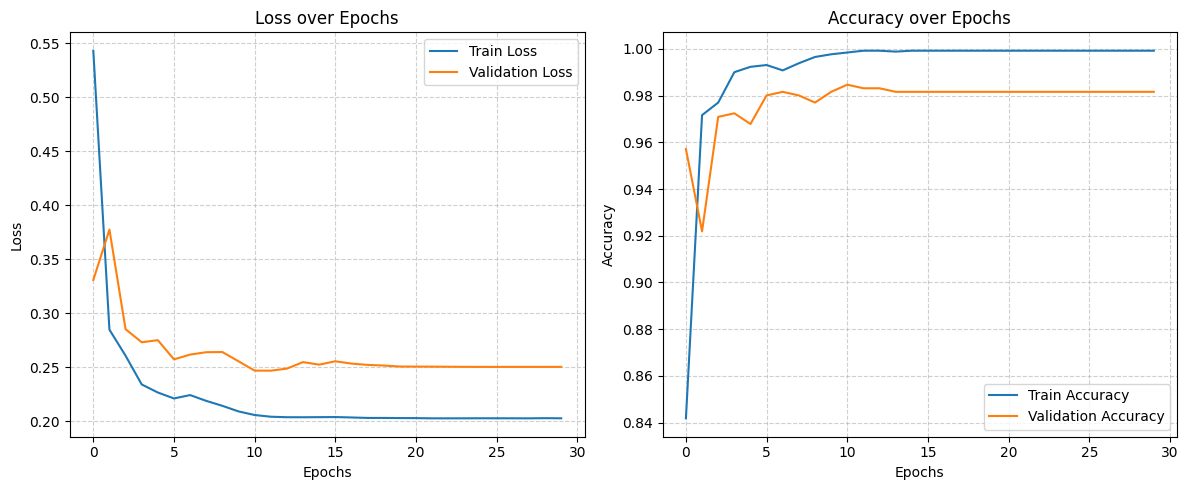

Building EnsembleModel with: ['swin_small_patch4_window7_224', 'deit_base_distilled_patch16_224', 'convnext_small']

Test Accuracy: 98.47%

Confusion matrix:
[[182   3   1   0]
 [  1 179   0   2]
 [  0   0 100   1]
 [  2   0   0 182]]

Classification report:
                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.98      0.98       186
meningioma_tumor       0.98      0.98      0.98       182
        no_tumor       0.99      0.99      0.99       101
 pituitary_tumor       0.98      0.99      0.99       184

        accuracy                           0.98       653
       macro avg       0.99      0.99      0.99       653
    weighted avg       0.98      0.98      0.98       653


Plotting confusion matrix...
Confusion matrix, without normalization


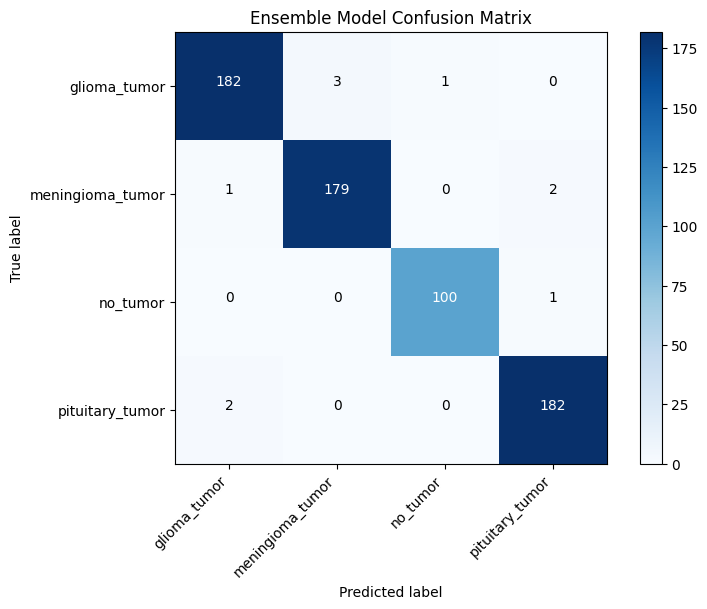


Grad-CAM skipped. Install pytorch-grad-cam (pip install grad-cam) and opencv-python to enable visualizations.


In [1]:
import os
import time
import copy
import itertools

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, classification_report

# Optional dependency: timm for many modern architectures
try:
    import timm
except Exception as e:
    timm = None
    print("Warning: timm is not installed. Install it with `pip install timm` to run the ensemble model.")
    # We continue, but build_model will error if timm is missing.

# ========================
# 1. Build Model — Ensemble wrapper over multiple timm models
# ========================
class EnsembleModel(nn.Module):
    """
    Ensemble of multiple models: average logits from each sub-model.
    Simple and effective way to combine complementary backbones.
    """
    def __init__(self, model_names, num_classes, pretrained=True, device='cuda'):
        super(EnsembleModel, self).__init__()
        if timm is None:
            raise ImportError("timm is required to create ensemble models. pip install timm")
        self.device = device
        self.model_names = model_names
        self.submodels = nn.ModuleList()
        for name in model_names:
            # Create model with final head sized to num_classes
            # timm will replace the head when num_classes != default.
            try:
                m = timm.create_model(name, pretrained=pretrained, num_classes=num_classes)
            except Exception as ex:
                raise RuntimeError(f"Failed to create timm model '{name}': {ex}")
            self.submodels.append(m)

    def forward(self, x):
        # Compute logits for each submodel and average
        logits = []
        for m in self.submodels:
            logits.append(m(x))
        # Stack: (n_models, batch, classes)
        stacked = torch.stack(logits, dim=0)
        avg = torch.mean(stacked, dim=0)
        return avg

def build_model(num_classes, device='cuda'):
    """
    Builds the ensemble model with a predefined list of models.
    You can edit the list `model_names` to include other timm models (memory permitting).
    """
    model_names = [
        "swin_small_patch4_window7_224",    # hierarchical transformer (local + global)
        "deit_base_distilled_patch16_224",  # data-efficient ViT variant
        "convnext_small"                    # modern convolutional backbone
    ]
    print("Building EnsembleModel with:", model_names)
    model = EnsembleModel(model_names=model_names, num_classes=num_classes, pretrained=True, device=device)
    return model

# ========================
# 2. Dataset and Loader (same layout & approach as your original script)
# ========================
# Directories (assuming Kaggle environment)
data_dir = '/kaggle/input/brain-tumor-classification-mri'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

# Check dataset existence early
if not os.path.isdir(train_dir) or not os.path.isdir(test_dir):
    raise RuntimeError(f"Training or Testing directory not found under {data_dir}. "
                       "Ensure the dataset is mounted/available with expected structure.")

# Transforms — keep ViT-friendly 224x224 and ImageNet normalization.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.08, contrast=0.08, saturation=0.08, hue=0.02),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load ImageFolder datasets without transforms for robust combined splitting / indexing
train_source_dataset_raw = datasets.ImageFolder(train_dir, transform=None)
test_source_dataset_raw = datasets.ImageFolder(test_dir, transform=None)

if len(train_source_dataset_raw) == 0 or len(test_source_dataset_raw) == 0:
    raise RuntimeError(f"Error: Could not load images from {train_dir} or {test_dir}. Check paths and content.")

# Combine datasets (same approach you used)
full_dataset_raw = ConcatDataset([train_source_dataset_raw, test_source_dataset_raw])
class_names = train_source_dataset_raw.classes
num_classes = len(class_names)

# Reproducibility
torch.manual_seed(42)
train_size = int(0.8 * len(full_dataset_raw))
val_size = len(full_dataset_raw) - train_size
generator = torch.Generator().manual_seed(42)
train_subset_indices, val_subset_indices = random_split(
    range(len(full_dataset_raw)), [train_size, val_size], generator=generator
)

# Custom Subset class to apply transforms (keeps same API as your original)
class TransformedSubset(Dataset):
    def __init__(self, full_dataset, indices, transform=None):
        self.full_dataset = full_dataset
        # If a Subset object is passed, random_split returns Subset with .indices attribute
        self.indices = indices if isinstance(indices, list) else indices.indices
        self.transform = transform

    def __getitem__(self, idx):
        full_idx = self.indices[idx]
        x, y = self.full_dataset[full_idx]  # x may be PIL image or tensor depending on underlying dataset
        if not isinstance(x, Image.Image):
             try:
                 x = transforms.functional.to_pil_image(x)
             except Exception:
                 pass
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.indices)

train_dataset = TransformedSubset(full_dataset_raw, train_subset_indices, transform=data_transforms['train'])
val_dataset = TransformedSubset(full_dataset_raw, val_subset_indices, transform=data_transforms['test'])

BATCH_SIZE = 24  # lower batch to reduce memory usage for multiple models
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=min(8, os.cpu_count()), pin_memory=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=min(8, os.cpu_count()), pin_memory=True)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
print(f"Classes: {class_names}")
print(f"Train: {dataset_sizes['train']} images, Val/Test: {dataset_sizes['val']} images")

# ========================
# 3. Training & Validation
# ========================
LEARNING_RATE = 3e-5  # conservative LR for fine-tuning pre-trained models
NUM_EPOCHS = 30
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Build ensemble model
model = build_model(num_classes=num_classes, device=device.type).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # small label smoothing
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

# Training loop (keeps same style as your original, adapted for ensemble)
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                scheduler.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f'New best validation accuracy: {best_acc:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

print("Training Ensemble BTGC model...")
trained_model, training_history = train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)

# Save the trained model
model_save_path = '/kaggle/working/BTGC_ensemble.pth'
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_history['train_loss'], label='Train Loss')
plt.plot(training_history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(training_history['train_acc'], label='Train Accuracy')
plt.plot(training_history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ========================
# 4. Test, Accuracy, Confusion Matrix
# ========================
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=min(8, os.cpu_count()))

# Reload best model for evaluation (reconstruct ensemble and load weights)
model_eval = build_model(num_classes=num_classes, device=device.type).to(device)
model_eval.load_state_dict(torch.load(model_save_path, map_location=device))
model_eval.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_eval(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = np.mean(all_preds == all_labels)
print(f'\nTest Accuracy: {accuracy*100:.2f}%')

cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion matrix:")
print(cm)
print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# ========================
# 5. Confusion Matrix Plot
# ========================
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print("\nPlotting confusion matrix...")
plot_confusion_matrix(cm, class_names, title='Ensemble Model Confusion Matrix')
plt.show()

# ========================
# 6. Explainable AI with Grad-CAM (basic, uses first submodel of the ensemble)
# ========================
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    from pytorch_grad_cam.utils.image import show_cam_on_image
    import cv2

    print("\nGenerating Grad-CAM explanations using the first ensemble submodel...")

    # Use first submodel for CAM visualization (simpler than combining internal activations)
    first_submodel = model_eval.submodels[0]

    # We try to pick a reasonable target layer for common timm models.
    # For ViT-like models it's often the last block's MLP or normalization; for ConvNeXt/Swin choose a feature layer.
    target_layers = None
    try:
        # Try a few common attribute names, stop at first that exists
        candidates = [
            # for ViT/DeiT-like: last encoder MLP or norm
            getattr(first_submodel, "blocks", None),
            getattr(first_submodel, "blocks", None),
            getattr(first_submodel, "layers", None),
            getattr(first_submodel, "features", None),
            getattr(first_submodel, "stages", None),
            getattr(first_submodel, "features", None)
        ]
        # We will attempt to find a linear/conv/norm module deeper in the model:
        # As a fallback, pick the last child module
        last_child = list(first_submodel.children())[-1]
        target_layers = [last_child]
        print("Selected target layer for Grad-CAM (fallback):", last_child)
    except Exception as e:
        print("Could not find convenient target layer for Grad-CAM:", e)
        target_layers = None

    if target_layers:
        # Prepare a few images from validation set for visualization
        vis_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        vis_dataset = TransformedSubset(full_dataset_raw, val_subset_indices, transform=vis_transform)
        num_images = min(4, len(vis_dataset))
        unnorm_imgs = []
        input_tensors = []
        for i in range(num_images):
            img_unnorm, _ = vis_dataset[i]  # unnormalized tensor form
            unnorm_imgs.append(img_unnorm)
            img_norm, _ = val_dataset[i]
            input_tensors.append(img_norm.unsqueeze(0))

        # reshape_transform may be required for ViT-like models; we attempt without reshape first.
        cam = GradCAM(model=first_submodel, target_layers=target_layers)
        for i in range(num_images):
            input_tensor = input_tensors[i].to(device)
            outputs = first_submodel(input_tensor)
            score = torch.softmax(outputs, dim=1)
            prob, prediction_idx = torch.max(score, 1)
            targets = [ClassifierOutputTarget(prediction_idx.item())]

            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]

            # Convert unnormalized tensor to HWC numpy (range 0-1)
            rgb_img = unnorm_imgs[i].permute(1, 2, 0).numpy()
            rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-8)
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

            true_label_idx = vis_dataset[i][1]
            true_class = class_names[true_label_idx]
            predicted_class = class_names[prediction_idx]

            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(rgb_img)
            axes[0].set_title(f'Original Image\nTrue: {true_class}')
            axes[0].axis('off')
            axes[1].imshow(visualization)
            axes[1].set_title(f'Grad-CAM\nPredicted: {predicted_class} ({prob.item()*100:.1f}%)')
            axes[1].axis('off')
            plt.tight_layout()
            plt.show()
    else:
        print("Skipping Grad-CAM: no suitable target layers found for the selected submodel.")

except ImportError:
    print("\nGrad-CAM skipped. Install pytorch-grad-cam (pip install grad-cam) and opencv-python to enable visualizations.")
except Exception as e:
    print(f"\nAn error occurred during Grad-CAM generation: {e}")
    print("Grad-CAM section skipped.")

In [2]:
!pip install grad-cam opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 90.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.4 MB/s eta 0:


Generating Grad-CAM explanations using the first ensemble submodel...
Generating CAM for submodel: swin_small_patch4_window7_224
Selected target layer for Grad-CAM: LayerNorm((768,), eps=1e-05, elementwise_affine=True)


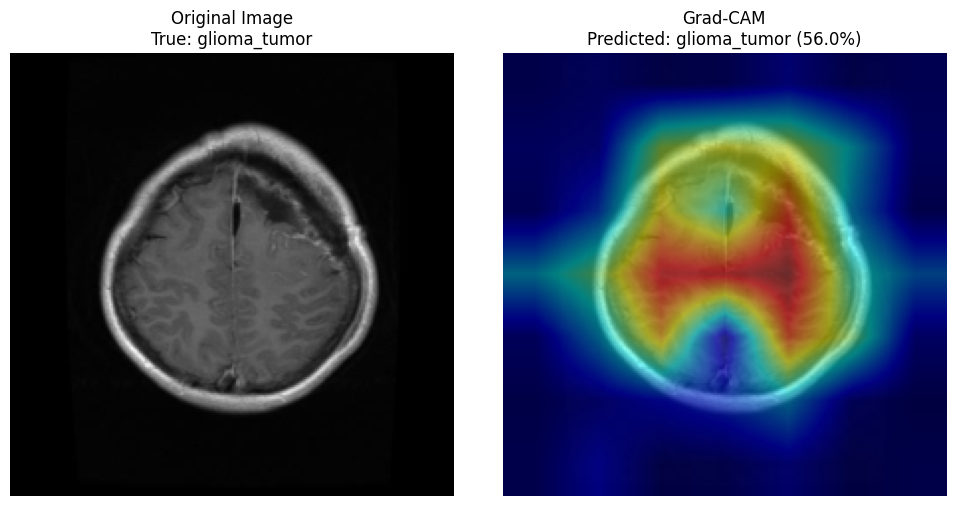

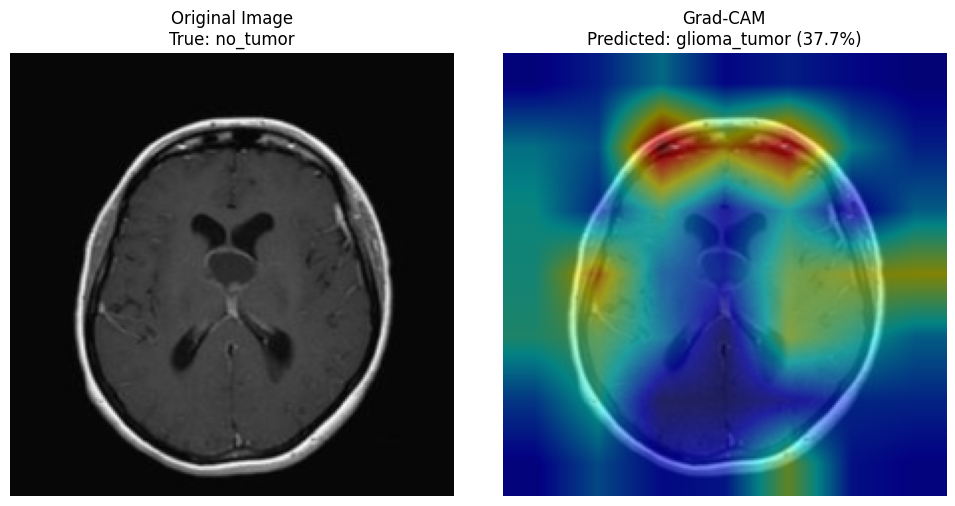

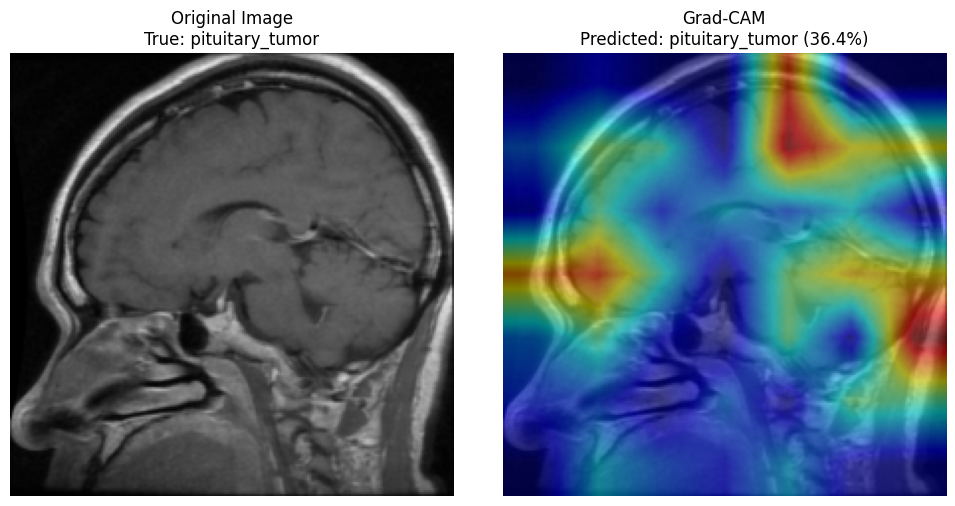

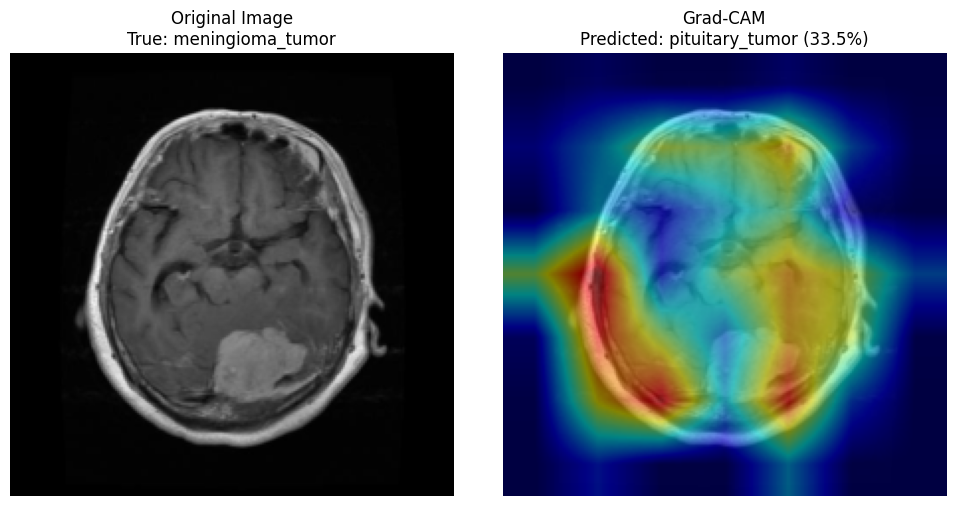

In [5]:
# ========================
# 6. Explainable AI with Grad-CAM (Fixed Reshape for Swin)
# ========================
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    from pytorch_grad_cam.utils.image import show_cam_on_image
    import cv2

    print("\nGenerating Grad-CAM explanations using the first ensemble submodel...")

    # Assumes 'model_eval' exists from the previous cell
    first_submodel = model_eval.submodels[0] # This is 'swin_small_patch4_window7_224'
    print(f"Generating CAM for submodel: {model.model_names[0]}")

    # *** KEY FIX: Correct reshape for 4D Swin output ***
    # The Swin 'norm' layer outputs (B, H, W, C)
    # We must permute it to (B, C, H, W)
    def reshape_transform_swin(tensor):
        # Input tensor shape: (B, H, W, C)
        try:
            # Permute to (B, C, H, W)
            tensor_chw = tensor.permute(0, 3, 1, 2)
            return tensor_chw
        except Exception as e:
            print(f"Error in reshape_transform: {e} with tensor shape {tensor.shape}")
            return tensor

    # Target the final 'norm' layer, which outputs (B, H, W, C)
    target_layers = None
    try:
        target_layers = [first_submodel.norm]
        print(f"Selected target layer for Grad-CAM: {target_layers[0]}")
    except Exception as e:
        print(f"Could not find default .norm layer: {e}.")
        target_layers = None

    if target_layers:
        # Prepare a few images from validation set for visualization
        # (This part is the same as your original code)
        vis_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        vis_dataset = TransformedSubset(full_dataset_raw, val_subset_indices, transform=vis_transform)
        num_images = min(4, len(vis_dataset))
        unnorm_imgs = []
        input_tensors = []
        for i in range(num_images):
            img_unnorm, _ = vis_dataset[i] # unnormalized tensor form
            unnorm_imgs.append(img_unnorm)
            img_norm, _ = val_dataset[i]
            input_tensors.append(img_norm.unsqueeze(0))

        # Pass the new reshape_transform to GradCAM
        cam = GradCAM(model=first_submodel, 
                      target_layers=target_layers, 
                      reshape_transform=reshape_transform_swin)

        for i in range(num_images):
            input_tensor = input_tensors[i].to(device)
            outputs = first_submodel(input_tensor)
            score = torch.softmax(outputs, dim=1)
            prob, prediction_idx = torch.max(score, 1)
            targets = [ClassifierOutputTarget(prediction_idx.item())]

            # This should now work without errors
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]

            # Convert unnormalized tensor to HWC numpy (range 0-1)
            rgb_img = unnorm_imgs[i].permute(1, 2, 0).numpy()
            rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-8)
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

            true_label_idx = vis_dataset[i][1]
            true_class = class_names[true_label_idx]
            predicted_class = class_names[prediction_idx]

            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(rgb_img)
            axes[0].set_title(f'Original Image\nTrue: {true_class}')
            axes[0].axis('off')
            axes[1].imshow(visualization)
            axes[1].set_title(f'Grad-CAM\nPredicted: {predicted_class} ({prob.item()*100:.1f}%)')
            axes[1].axis('off')
            plt.tight_layout()
            plt.show()
    else:
        print("Skipping Grad-CAM: no suitable target layers found for the selected submodel.")

except ImportError:
    print("\nGrad-CAM skipped. Install pytorch-grad-cam (pip install grad-cam) and opencv-python to enable visualizations.")
except Exception as e:
    print(f"\nAn error occurred during Grad-CAM generation: {e}")
    print("Grad-CAM section skipped.")